In [1]:
! pip install -q kaggle
# from google.colab import files
# files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shahabhosseini1","key":"da54add8d442239d0469c017493d4e98"}'}

In [2]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

/bin/bash: line 1: kaggle: command not found


In [5]:
# ! kaggle datasets download "franciscoescobar/satellite-images-of-water-bodies"
import opendatasets as od


od.download_kaggle_dataset("franciscoescobar/satellite-images-of-water-bodies", data_dir='./aerial_dataset')

100%|████████████████████████████████████████████████████████████████████████████████| 247M/247M [00:04<00:00, 57.0MB/s]


In [1]:
from zipfile import ZipFile


file = "./aerial_dataset/satellite-images-of-water-bodies.zip"
with ZipFile(file, 'r') as zip:
    # list all the contents of the zip file
    # zip.printdir()
    print('extraction...')
    zip.extractall()
    print('Done!')

FileNotFoundError: [Errno 2] No such file or directory: './aerial_dataset/satellite-images-of-water-bodies.zip'

In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from google.colab import drive
import torchvision

In [2]:
def get_bounding_box(mask):
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    H, W = mask.shape
    x_min = max(0, x_min - np.random.randint(0, 10))
    x_max = min(W, x_max + np.random.randint(0, 10))
    y_min = max(0, y_min - np.random.randint(0, 10))
    y_max = min(H, y_max + np.random.randint(0, 10))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [3]:
class AerialDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        # image = np.array(Image.open(img_path).convert("RGB"))
        # mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # if self.transform is not None:
        #     augmentations = self.transform(image=image, mask=mask)
        #     image = augmentations["image"]
        #     mask = augmentations["mask"]
        if self.transform is not None:
            image, mask = self.transform(image, mask)

        return image, mask

In [4]:
import torchvision.transforms.v2 as T
from torchvision.transforms.v2 import functional as TF


class AerialDatasetSAM(Dataset):
    def __init__(self, image_dir, mask_dir,processor, image_transform, mask_transform):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.processor = processor
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        # image = np.array(Image.open(img_path).convert("RGB"))
        # mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32) / 255
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # if self.transform is not None:
        #     augmentations = self.transform(image=image, mask=mask)
        #     image = augmentations["image"]
        #     mask = augmentations["mask"]
        #     print(image.shape, mask.shape)
        image = self.image_transform(image)
        mask = self.mask_transform(mask)
            # mask = self.transform(image, mask)
        inputs = self.processor(image, input_boxes=[[get_bounding_box(mask.squeeze().numpy())]], return_tensors="pt")
        # remove additional batch created by sam processor because we have pytorch dataset batch
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        # print(inputs['pixel_values'])
        mask[mask < 0.04] = 0.
        mask[mask >= 0.04] = 1.
        # mask[mask != 0] = 1.
        inputs["gt_mask"] = mask

        return inputs

# transform = A.Compose([
#     A.geometric.resize.Resize(1024,1024)
# ])

transform = T.Compose([
    T.Resize((1024, 1024)),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
])

image_transform = T.Compose([
    T.Resize((1024, 1024)),
#     T.ToImage(),
#     T.ToDtype(torch.float32, scale=False),
])

mask_transform = T.Compose([
    T.Resize((1024, 1024)),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=False),
])

In [5]:
from transformers import SamModel
from transformers import SamProcessor
model = SamModel.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
# only fine tune mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

In [6]:
# train_ds = AerialDataset(
#     image_dir="./aerial_dataset/satellite-images-of-water-bodies/Water Bodies Dataset/Images",
#     mask_dir="./aerial_dataset/satellite-images-of-water-bodies/Water Bodies Dataset/Masks",
# )

# print(len(train_ds))



# train_dataloader = DataLoader(train_ds, batch_size=1, shuffle=True)

# image,mask = next(iter(train_dataloader))
# print(image.shape)
# print(mask.shape)
train_ds = AerialDatasetSAM(
        image_dir="./aerial_dataset/satellite-images-of-water-bodies/Water Bodies Dataset/Images",
        mask_dir="./aerial_dataset/satellite-images-of-water-bodies/Water Bodies Dataset/Masks",
        processor=processor,
        image_transform=image_transform,
        mask_transform=mask_transform,
)

def collate_fn(batch):
    pixel_values = torch.stack([d['pixel_values'] for d in batch])
    original_sizes = torch.stack([d['original_sizes'] for d in batch])
    reshaped_input_sizes = torch.stack([d['reshaped_input_sizes'] for d in batch])
    input_boxes = torch.stack([d['input_boxes'] for d in batch])
    gt_mask = torch.stack([d['gt_mask'] for d in batch])
    return {
        'pixel_values': pixel_values,
        'original_sizes': original_sizes,
        'reshaped_input_sizes': reshaped_input_sizes,
        'input_boxes': input_boxes,
        'gt_mask': gt_mask,
    }

train_dataloader_sam = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate_fn)

processor_output = next(iter(train_dataloader_sam))
for k,v in processor_output.items():
    try: print(k,v.shape)
    except AttributeError: print(k, len(v))

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
gt_mask torch.Size([2, 1, 1024, 1024])


In [22]:
train_ds[0]

{'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-

In [21]:
processor_output['pixel_values']

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

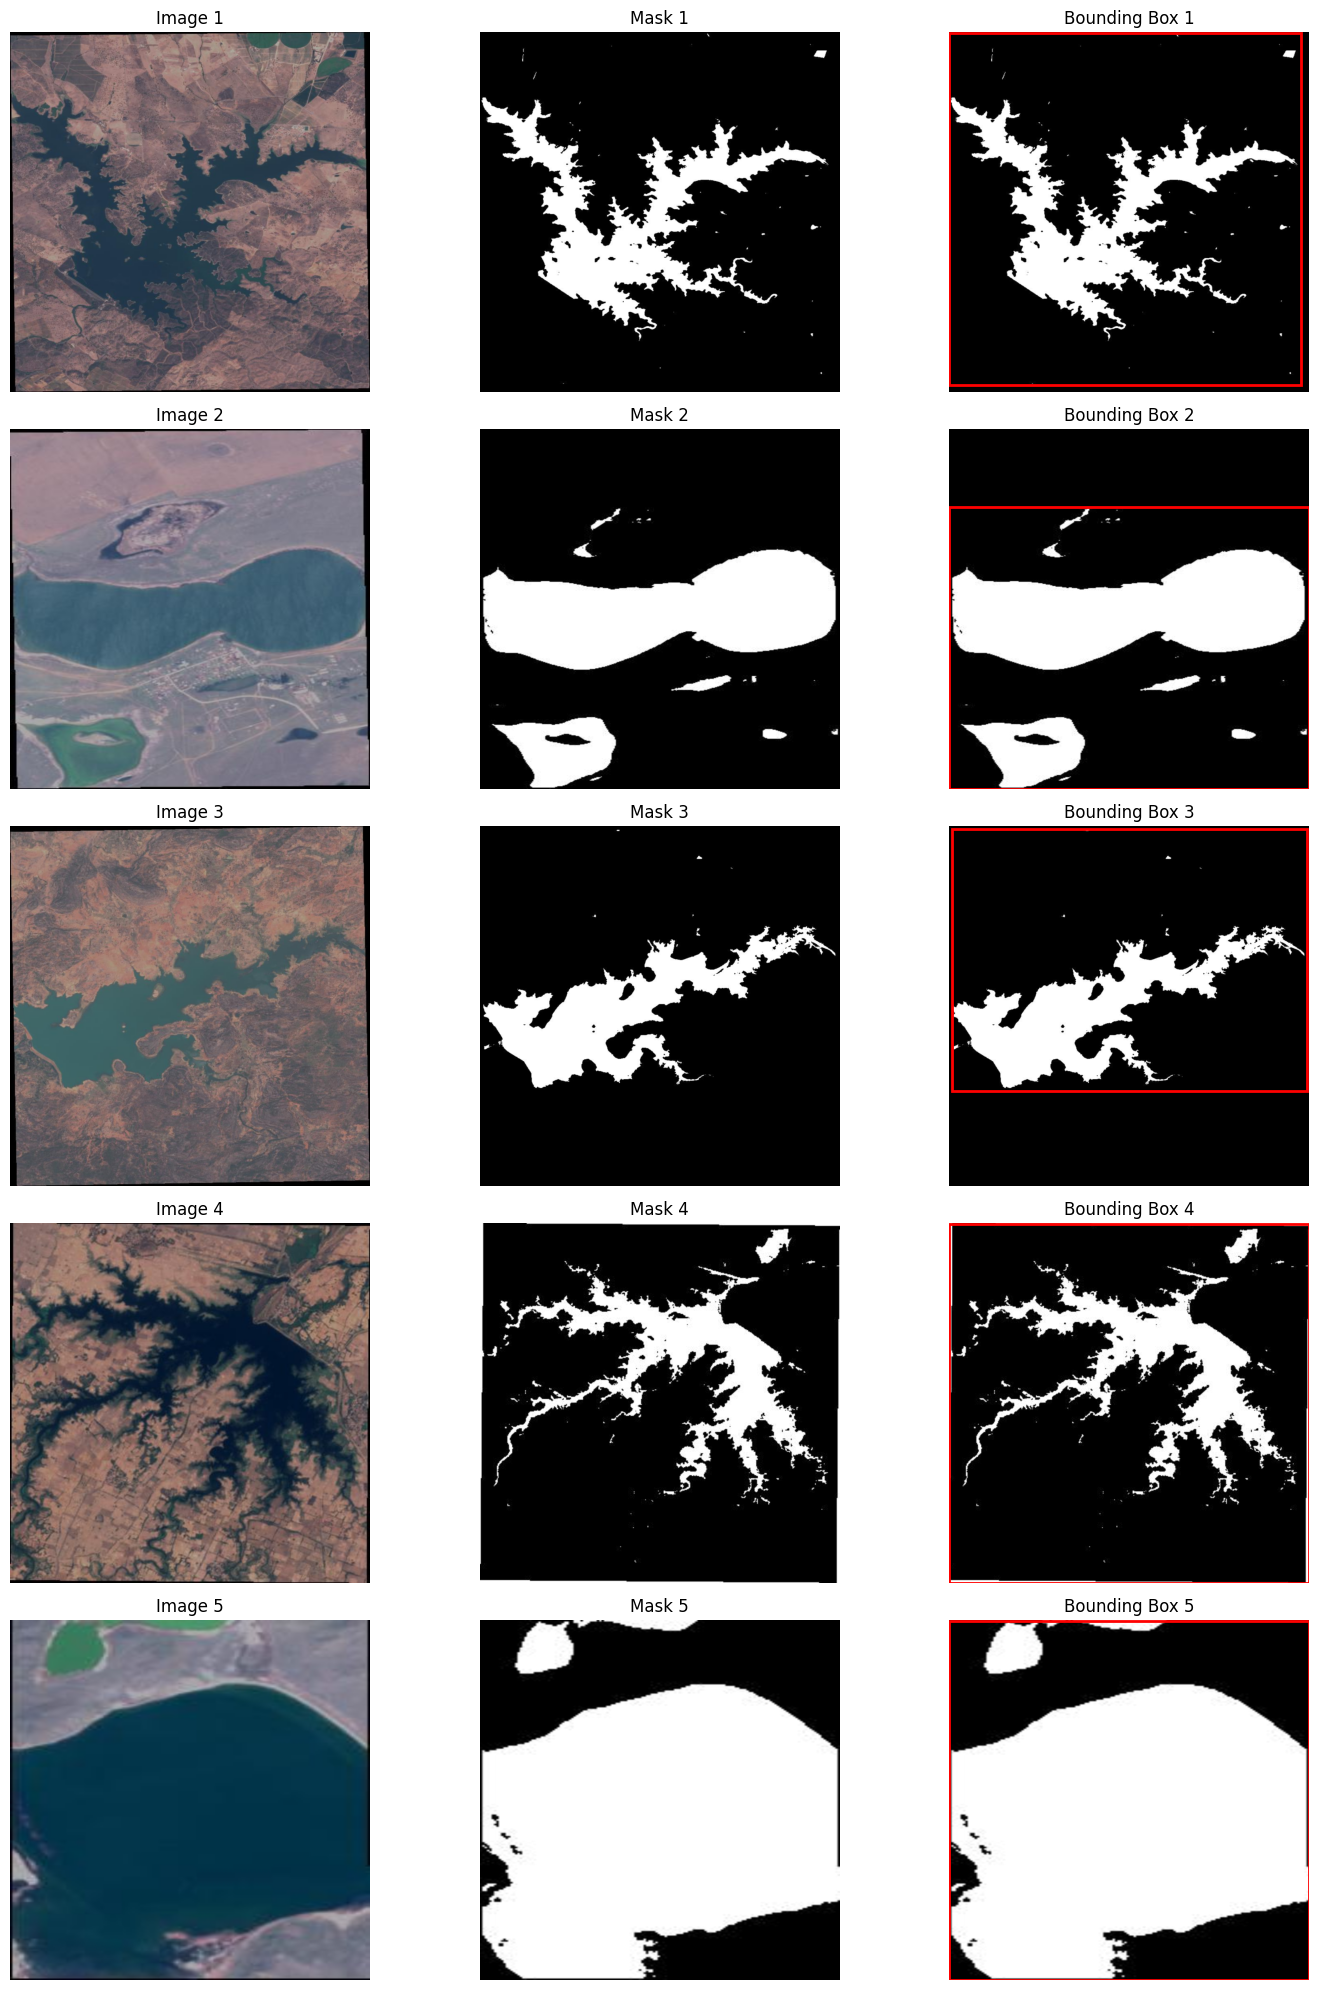

In [7]:
import matplotlib.pyplot as plt
import random
import numpy as np

dataset = AerialDataset(
    image_dir="./aerial_dataset/satellite-images-of-water-bodies/Water Bodies Dataset/Images",
    mask_dir="./aerial_dataset/satellite-images-of-water-bodies/Water Bodies Dataset/Masks",
    transform = transform
)

# Get 5 random indices
random_indices = random.sample(range(len(dataset)), 5)

# Plot the images, masks, and bounding boxes
fig, axes = plt.subplots(5, 3, figsize=(15, 20))

for i, idx in enumerate(random_indices):
    image, mask = dataset[idx]
    image, mask = torch.movedim(image, 0, 2), torch.movedim(mask, 0, 2)

    # Get bounding box
    bbox = get_bounding_box(mask.squeeze().numpy())

    # Display image
    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f"Image {i+1}")
    axes[i, 0].axis("off")

    # Display mask
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title(f"Mask {i+1}")
    axes[i, 1].axis("off")

    # Display bounding box
    axes[i, 2].imshow(mask, cmap='gray')
    axes[i, 2].add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none'))
    axes[i, 2].set_title(f"Bounding Box {i+1}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1024, 1024, 3])
torch.Size([1024, 1024, 3])


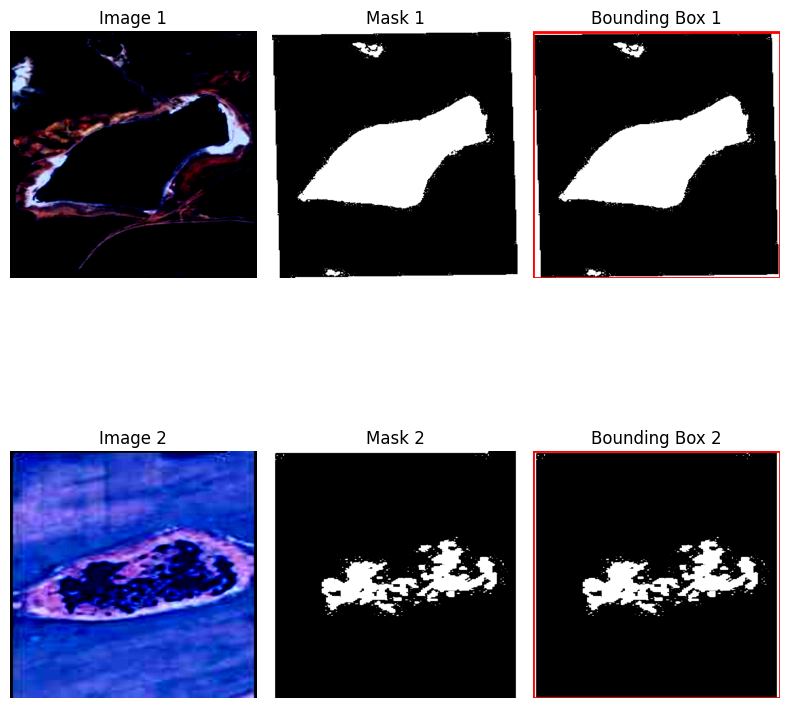

In [8]:
import matplotlib.pyplot as plt
import random
import numpy as np

dataset = AerialDatasetSAM(
        image_dir='./aerial_dataset/satellite-images-of-water-bodies/Water Bodies Dataset/Images',
        mask_dir='./aerial_dataset/satellite-images-of-water-bodies/Water Bodies Dataset/Masks',
        processor=processor,
        image_transform=image_transform,
        mask_transform=mask_transform,
)

# Get 5 random indices
random_indices = random.sample(range(len(dataset)), 2)
random_indices = np.asarray([1838, 1357])

# Plot the images, masks, and bounding boxes
fig, axes = plt.subplots(2, 3, figsize=(8, 10))

for i, idx in enumerate(random_indices):
    images = dataset[idx]
    image = images["pixel_values"]
    mask = images["gt_mask"]
    image, mask = torch.movedim(image, 0, 2), torch.movedim(mask, 0, 2)
    # Get bounding box
    bbox = get_bounding_box(mask.squeeze().numpy())

    # Display image
    print(image.shape)
    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f"Image {i+1}")
    axes[i, 0].axis("off")

    # Display mask
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title(f"Mask {i+1}")
    axes[i, 1].axis("off")

    # Display bounding box
    axes[i, 2].imshow(mask, cmap='gray')
    axes[i, 2].add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none'))
    axes[i, 2].set_title(f"Bounding Box {i+1}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# !pip install -q monai

In [7]:
#Training Loop
from torch.utils.data import random_split
from torch.optim import Adam
import monai
# ADAM optimizer
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5)
# DICE LOSS
dice_loss_fn = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# transform = A.Compose([
#   A.geometric.resize.Resize(256,256)
# ])

transform = T.Compose([
    T.Resize((1024, 1024)),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
])

# Calculate the lengths for train and test datasets
total_length = len(train_ds)
train_length = int(0.90 * total_length)
test_length = total_length - train_length

# Split the dataset
train_data, test_data = random_split(train_ds, [train_length, test_length])

# Create data loaders
train_dataloader_sam = DataLoader(train_data, batch_size=4, shuffle=True,  collate_fn=collate_fn)
test_dataloader_sam = DataLoader(test_data, batch_size=4, shuffle=False,  collate_fn=collate_fn)
# Print the lengths
print("Total dataset length:", total_length)
print("Train dataset length:", train_length)
print("Test dataset length:", test_length)

Total dataset length: 2841
Train dataset length: 2556
Test dataset length: 285


$
IoU(A, B) = \frac{|A \cap B|}{|A \cup B|}
$

In [8]:
def calculate_iou(predicted_masks, ground_truth_masks):
    intersection = torch.sum(predicted_masks * ground_truth_masks)
    union = torch.logical_or(predicted_masks, ground_truth_masks)

    iou = torch.sum(intersection) / torch.sum(union)

    return iou

$Dice(A, B) = \frac{2 \times |A \cap B|}{|A| + |B|}$

In [9]:
def calculate_dice_coefficient(predicted_masks, ground_truth_masks):
    intersection = torch.sum(predicted_masks * ground_truth_masks)
    cardinality_sum = torch.sum(predicted_masks) + torch.sum(ground_truth_masks)

    dice_coefficient = (2.0 * intersection) / cardinality_sum

    return dice_coefficient

In [10]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from torchvision.transforms.functional import resize
#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
epoch_dices = []
epoch_ious = []
mean_loss =[]
model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader_sam):
        optimizer.zero_grad()
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["gt_mask"].to(device)
        resized_gt_masks = resize(ground_truth_masks, (256, 256))
        loss = dice_loss_fn(predicted_masks, resized_gt_masks)
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_dices.append(calculate_dice_coefficient(predicted_masks,resized_gt_masks).item())
        epoch_ious.append(calculate_iou(predicted_masks,resized_gt_masks).item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    mean_loss.append(mean(epoch_losses))

  0%|                                                                                           | 0/639 [00:00<?, ?it/s]/home/arash/myenv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████| 639/639 [04:23<00:00,  2.43it/s]


EPOCH: 0
Mean loss: 1.4322583699636802


100%|█████████████████████████████████████████████████████████████████████████████████| 639/639 [04:24<00:00,  2.42it/s]


EPOCH: 1
Mean loss: 1.431484900683118


100%|█████████████████████████████████████████████████████████████████████████████████| 639/639 [04:27<00:00,  2.39it/s]


EPOCH: 2
Mean loss: 1.4316402327193527


100%|█████████████████████████████████████████████████████████████████████████████████| 639/639 [04:26<00:00,  2.40it/s]


EPOCH: 3
Mean loss: 1.4312616500869417


100%|█████████████████████████████████████████████████████████████████████████████████| 639/639 [04:25<00:00,  2.41it/s]


EPOCH: 4
Mean loss: 1.431369662564685


100%|█████████████████████████████████████████████████████████████████████████████████| 639/639 [04:25<00:00,  2.40it/s]


EPOCH: 5
Mean loss: 1.4306099065032922


100%|█████████████████████████████████████████████████████████████████████████████████| 639/639 [04:29<00:00,  2.38it/s]


EPOCH: 6
Mean loss: 1.432094737304395


100%|█████████████████████████████████████████████████████████████████████████████████| 639/639 [04:25<00:00,  2.40it/s]


EPOCH: 7
Mean loss: 1.431757388540277


100%|█████████████████████████████████████████████████████████████████████████████████| 639/639 [04:27<00:00,  2.39it/s]


EPOCH: 8
Mean loss: 1.4314228009916434


100%|█████████████████████████████████████████████████████████████████████████████████| 639/639 [04:25<00:00,  2.41it/s]

EPOCH: 9
Mean loss: 1.4313985763674424


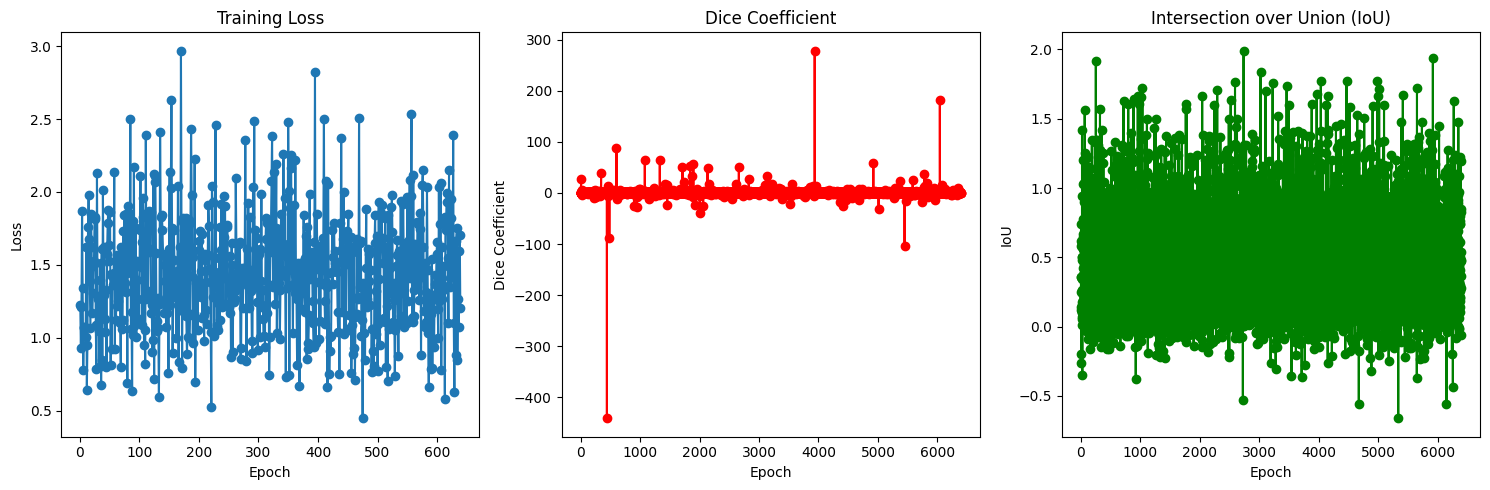

In [22]:
import matplotlib.pyplot as plt


# samples_size = 0
# for batch in train_dataloader_sam:
#     samples_size += len(batch['pixel_values'])
number_of_batches = (samples_size // 4)

# Plotting
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, number_of_batches + 1), epoch_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot Dice Scores
plt.subplot(1, 3, 2)
plt.plot(range(1, 6390 + 1), epoch_dices, marker='o', color='r')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')

# Plot IoU
plt.subplot(1, 3, 3)
plt.plot(range(1, 6390 + 1), epoch_ious, marker='o', color='g')
plt.title('Intersection over Union (IoU)')
plt.xlabel('Epoch')
plt.ylabel('IoU')

plt.tight_layout()
plt.show()

In [23]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Lists to store predictions and ground truth for visualization
all_predictions = []
all_ground_truth = []

with torch.no_grad():
    i=0
    for batch in tqdm(test_dataloader_sam):  # Assuming you have a separate test dataloader
        i+=1
        if(i==20):
            break
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["gt_mask"].to(device)

        # Resize ground truth masks for visualization
        resized_gt_masks = resize(ground_truth_masks, (256, 256))

        # Compute and store predictions and ground truth for visualization
        all_predictions.append(predicted_masks.cpu().numpy())
        all_ground_truth.append(resized_gt_masks.cpu().numpy())

# Convert lists to NumPy arrays for easier manipulation
all_predictions = np.array(all_predictions)
all_ground_truth = np.array(all_ground_truth)

 26%|█████████████████████▉                                                             | 19/72 [00:10<00:28,  1.87it/s]


(19, 4, 1, 256, 256)


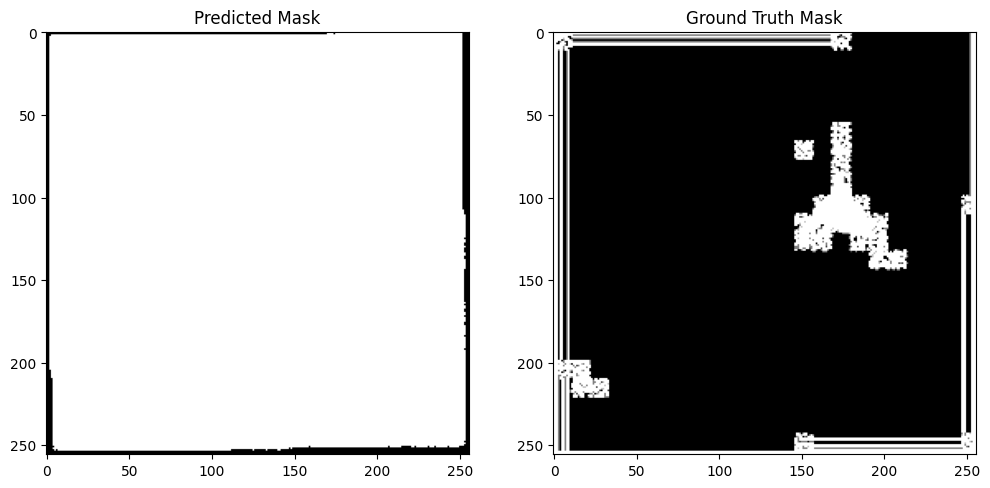

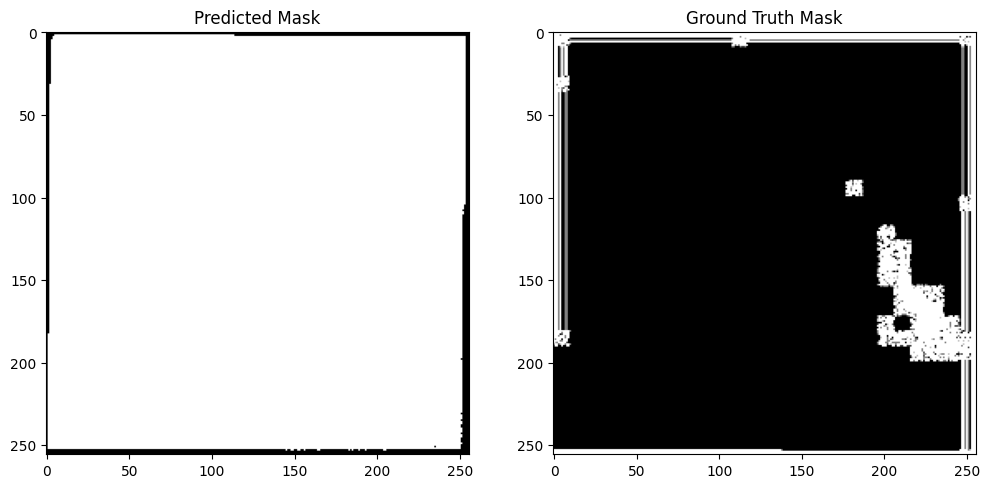

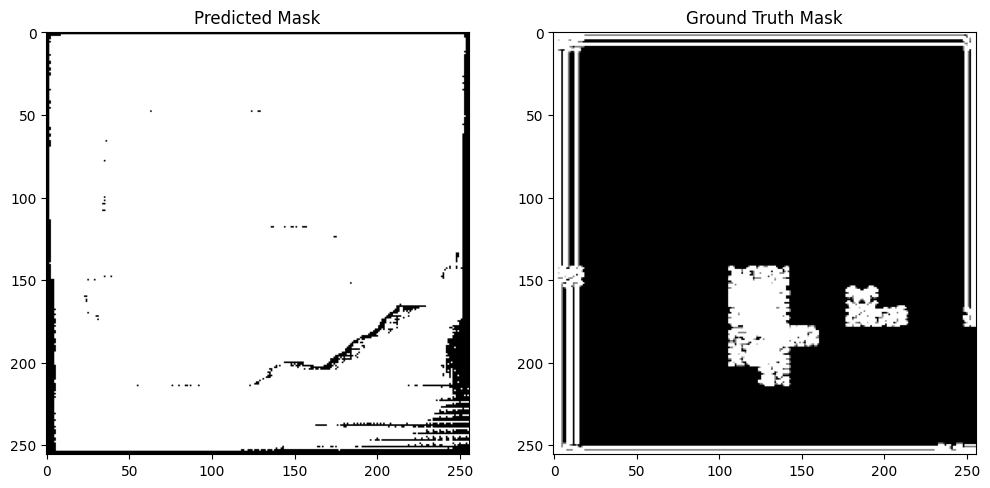

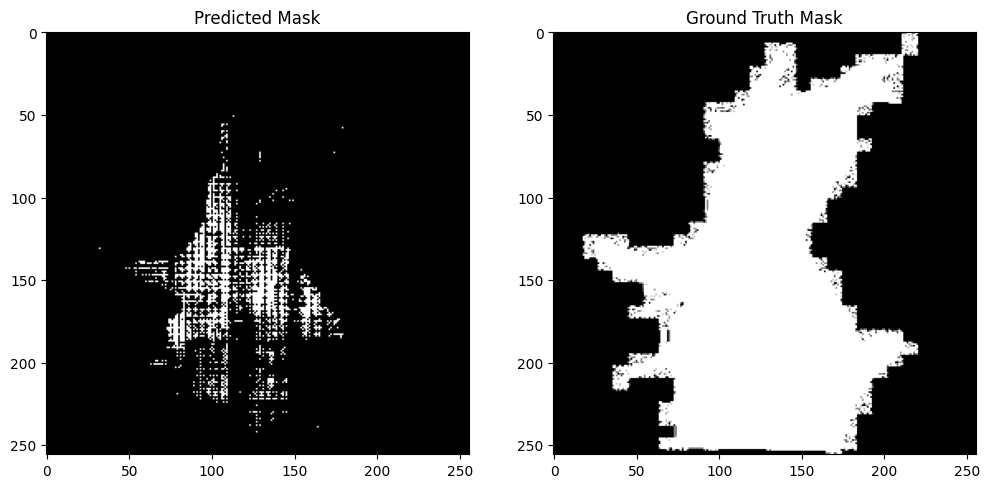

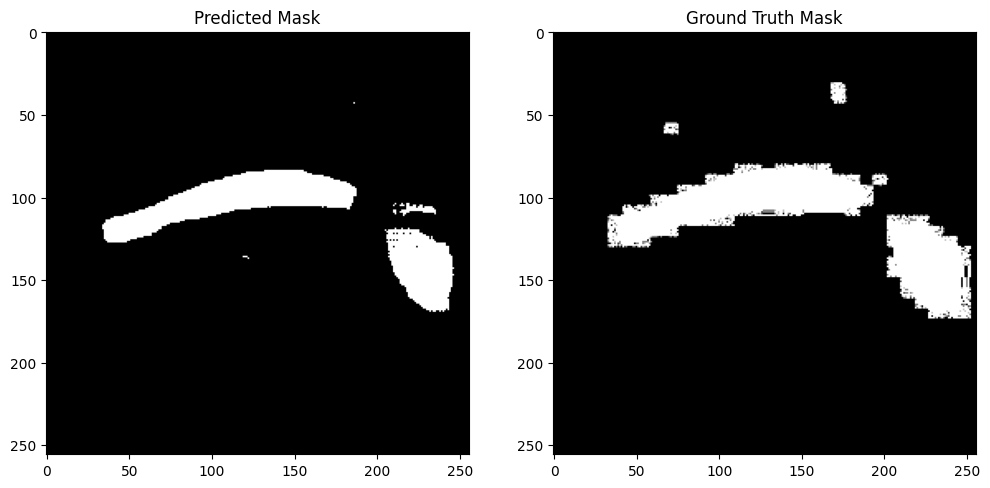

In [25]:
num_examples_to_plot = 5
print(all_predictions.shape)
for i in range(num_examples_to_plot):
    plt.figure(figsize=(12, 6))

    # Plot predicted mask
    plt.subplot(1, 2, 1)
    prediction = all_predictions[i, 0].squeeze()
    # prediction = torch.sigmoid(torch.tensor(prediction)).numpy()
    prediction = (prediction > 0.5).astype(np.uint8)
    plt.imshow(prediction, cmap="gray")
    plt.title("Predicted Mask")

    # Plot ground truth mask
    plt.subplot(1, 2, 2)
    plt.imshow(all_ground_truth[i, 0].squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")

    plt.show()